<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/9_ResNetsandHigherReceptiveFields/experiments/CIFAR10_Image_Classification_CustomResnet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary
!pip install torch-lr-finder
!pip install hiddenlayer

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-kmwdvwg2
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-kmwdvwg2
  Created wheel for albumentations: filename=albumentations-1.0.1-cp37-none-any.whl size=98530 sha256=5f471b009c455eeeba63e1b86ee97645c2876ed14d401f7810cd08a649e3ddb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-379f5zph/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [ ]:
# !git clone https://github.com/gkdivya/torch_cv_wrapper.git /content/drive/MyDrive/Cifar10_Resnet/session9/torch_cv_wrapper

In [ ]:
%cd "/content/drive/MyDrive/Cifar10_Resnet/session9/"
from __future__ import print_function
import torchvision
import torch
from pprint import pprint
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

## Import Custom Libraries
from torch_cv_wrapper.utils import plot_metrics,train,test,helper
from torch_cv_wrapper.utils.gradcam import generate_gradcam, plot_gradcam
from torch_cv_wrapper.model import customresnet
from torch_cv_wrapper.main import TriggerEngine

/content/drive/MyDrive/Cifar10_Resnet/session9


## Load config file

In [ ]:
config = helper.process_config("/content/drive/MyDrive/Cifar10_Resnet/session9/session9.yaml")
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'type': 'CIFAR10AlbumentationS9'},
 'data_loader': {'args': {'batch_size': 512,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': ['plane',
                             'car',
                             'bird',
                             'cat',
                             'deer',
                             'dog',
                             'frog',
                             'horse',
                             'ship',
                             'truck'],
                 'type': 'Cifar10DataLoader'},
 'lr_scheduler': 'OneCycleLR',
 'model': 'CustomResnet',
 'model_params': {'dropout': 0.05,
                  'experiment_name': 'cifar10_with_customresnet',
                  'model_dir': './model/',
                  'seed': 1},
 'optimizer': {'args': {'lr': 0.001}, 'type': 'optim.SGD'},
 'training_params'

## Create Training Instance

In [ ]:
exp_metrics={}
experiment_name=config['model_params']['experiment_name']
trigger_training=TriggerEngine(config)

## Download data and view sample images

In [ ]:
classes= config['data_loader']['classes']

#Get dataloaders
train_loader,test_loader = trigger_training.dataloader()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


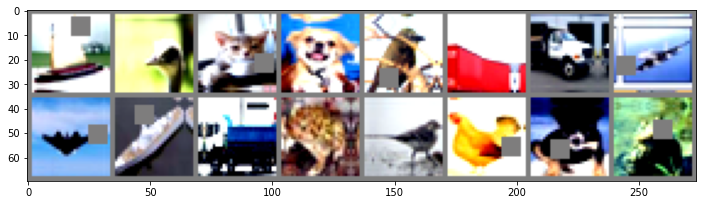

In [ ]:
# get some random training images
images, labels = iter(train_loader).next()

# # show images
helper.imshow(torchvision.utils.make_grid(images[:16]))

## Model Summary

In [ ]:
model = customresnet.CustomResNet()
model.to(device)
trigger_training.model_summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Visualize Network Architecture

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


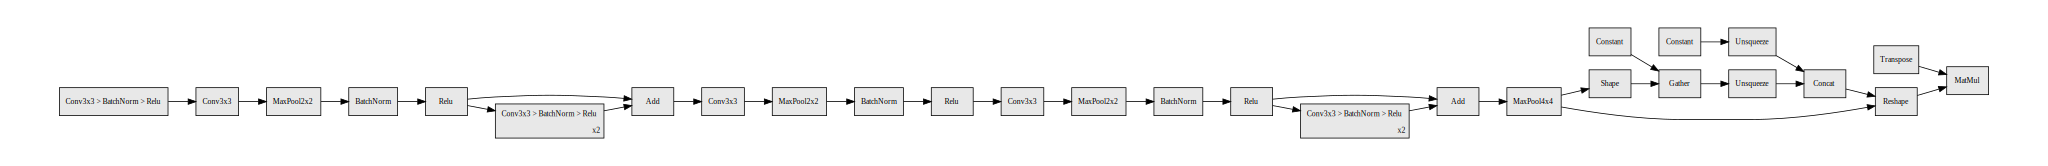

In [ ]:
import hiddenlayer as hl
input = torch.zeros([1, 3, 32, 32])
hl.build_graph(model, input.to(device))

## Find Best LR


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.04E-02


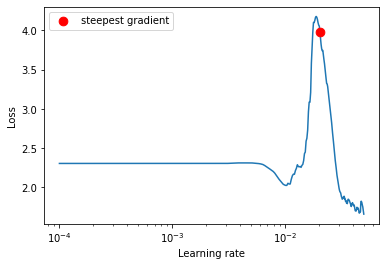

In [ ]:
start_lr = 1e-4
end_lr = 0.05
num_iterations = len(test_loader) * 25
lrmax= trigger_training.find_lr(model,train_loader, test_loader, start_lr, end_lr, num_iterations)

## Trigger training

In [ ]:
# trigger_training.

(exp_metrics[experiment_name]) = trigger_training.run_experiment(model,train_loader,test_loader,lrmax)

  0%|          | 0/98 [00:00<?, ?it/s]

using OneCycleLR
Epoch 1:


Loss=1.263157606124878 Batch_id=97 LR=0.00380 Accuracy=41.55: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5420/10000 (54.20%)

Epoch 2:


Loss=0.823064923286438 Batch_id=97 LR=0.00841 Accuracy=60.60: 100%|██████████| 98/98 [00:14<00:00,  6.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6559/10000 (65.59%)

Epoch 3:


Loss=0.8730536103248596 Batch_id=97 LR=0.01410 Accuracy=68.19: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6945/10000 (69.45%)

Epoch 4:


Loss=0.641173243522644 Batch_id=97 LR=0.01868 Accuracy=73.35: 100%|██████████| 98/98 [00:14<00:00,  6.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 6315/10000 (63.15%)

Epoch 5:


Loss=0.781368613243103 Batch_id=97 LR=0.02041 Accuracy=77.23: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 7368/10000 (73.68%)

Epoch 6:


Loss=0.7068363428115845 Batch_id=97 LR=0.02027 Accuracy=80.07: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7945/10000 (79.45%)

Epoch 7:


Loss=0.47721394896507263 Batch_id=97 LR=0.01986 Accuracy=82.39: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8319/10000 (83.19%)

Epoch 8:


Loss=0.49573779106140137 Batch_id=97 LR=0.01919 Accuracy=84.90: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8357/10000 (83.57%)

Epoch 9:


Loss=0.4183359742164612 Batch_id=97 LR=0.01827 Accuracy=85.99: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8412/10000 (84.12%)

Epoch 10:


Loss=0.4343528747558594 Batch_id=97 LR=0.01714 Accuracy=87.17: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8295/10000 (82.95%)

Epoch 11:


Loss=0.4757011830806732 Batch_id=97 LR=0.01582 Accuracy=88.18: 100%|██████████| 98/98 [00:14<00:00,  6.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8620/10000 (86.20%)

Epoch 12:


Loss=0.27969568967819214 Batch_id=97 LR=0.01435 Accuracy=89.32: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8714/10000 (87.14%)

Epoch 13:


Loss=0.34953269362449646 Batch_id=97 LR=0.01277 Accuracy=90.81: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8802/10000 (88.02%)

Epoch 14:


Loss=0.2555983364582062 Batch_id=97 LR=0.01112 Accuracy=91.53: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8798/10000 (87.98%)

Epoch 15:


Loss=0.18109723925590515 Batch_id=97 LR=0.00946 Accuracy=92.51: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8829/10000 (88.29%)

Epoch 16:


Loss=0.12450876832008362 Batch_id=97 LR=0.00781 Accuracy=93.28: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8945/10000 (89.45%)

Epoch 17:


Loss=0.17222608625888824 Batch_id=97 LR=0.00623 Accuracy=93.79: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8918/10000 (89.18%)

Epoch 18:


Loss=0.13230900466442108 Batch_id=97 LR=0.00477 Accuracy=94.79: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8961/10000 (89.61%)

Epoch 19:


Loss=0.12032783776521683 Batch_id=97 LR=0.00345 Accuracy=95.37: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9007/10000 (90.07%)

Epoch 20:


Loss=0.08646611124277115 Batch_id=97 LR=0.00232 Accuracy=96.18: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9053/10000 (90.53%)

Epoch 21:


Loss=0.12495875358581543 Batch_id=97 LR=0.00141 Accuracy=96.71: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9078/10000 (90.78%)

Epoch 22:


Loss=0.10342182219028473 Batch_id=97 LR=0.00075 Accuracy=97.00: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9095/10000 (90.95%)

Epoch 23:


Loss=0.08668550848960876 Batch_id=97 LR=0.00034 Accuracy=97.41: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9093/10000 (90.93%)

Epoch 24:


Loss=0.061694152653217316 Batch_id=97 LR=0.00020 Accuracy=97.41: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]



Test set: Average loss: 0.0006, Accuracy: 9088/10000 (90.88%)



## Missclassification

Total wrong predictions are 912
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


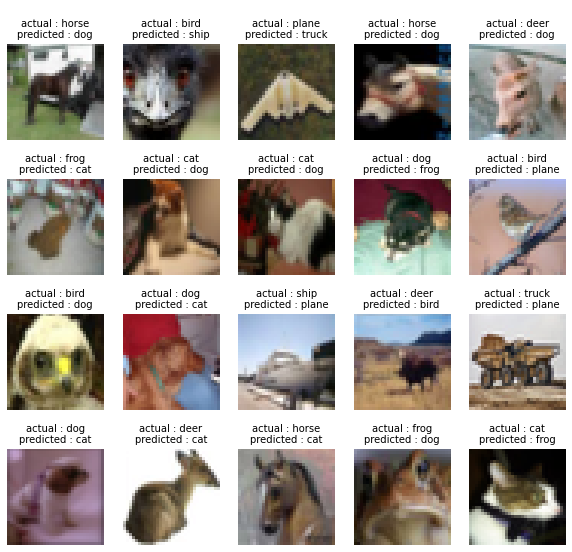

In [ ]:
misclassified_images = trigger_training.wrong_predictions(model,test_loader)

## Plots for Validation Loss and Accuracy

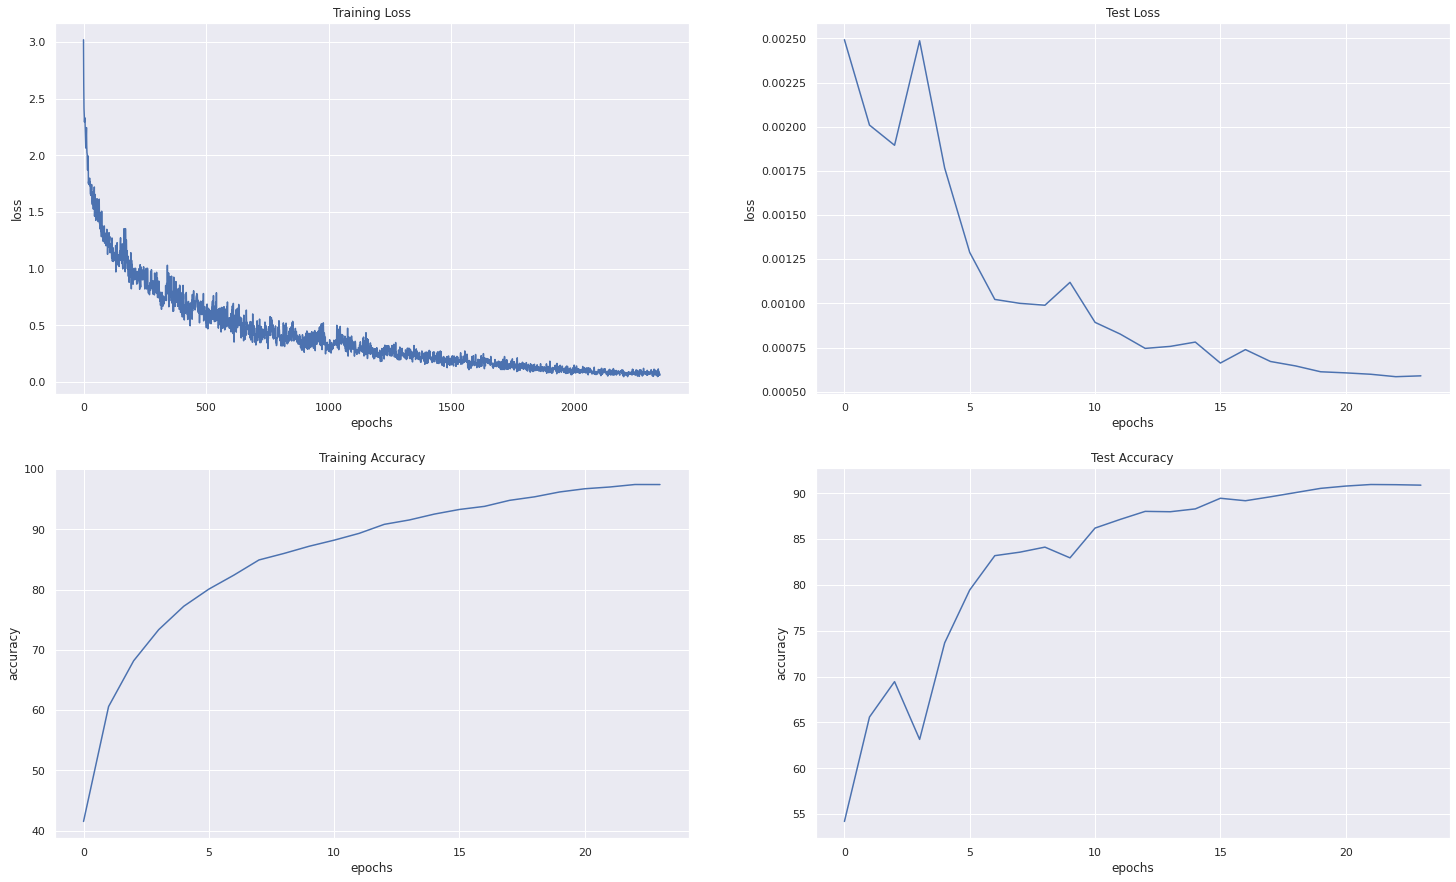

In [ ]:
plot_metrics.plot_metrics(exp_metrics[experiment_name])

## Accuracy for each class

In [ ]:
helper.class_level_accuracy(model, test_loader, device, classes)

Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 86 %
Accuracy of   cat : 78 %
Accuracy of  deer : 92 %
Accuracy of   dog : 87 %
Accuracy of  frog : 94 %
Accuracy of horse : 91 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %


## Plot Confusion Matrix

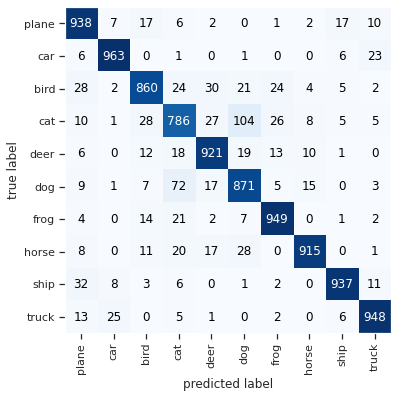

In [ ]:
mat = helper.compute_confusion_matrix(model,test_loader,device)
plot_metrics.plot_confusion_matrix(mat, class_names=classes)


## Generate & Plot GradCam Images

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


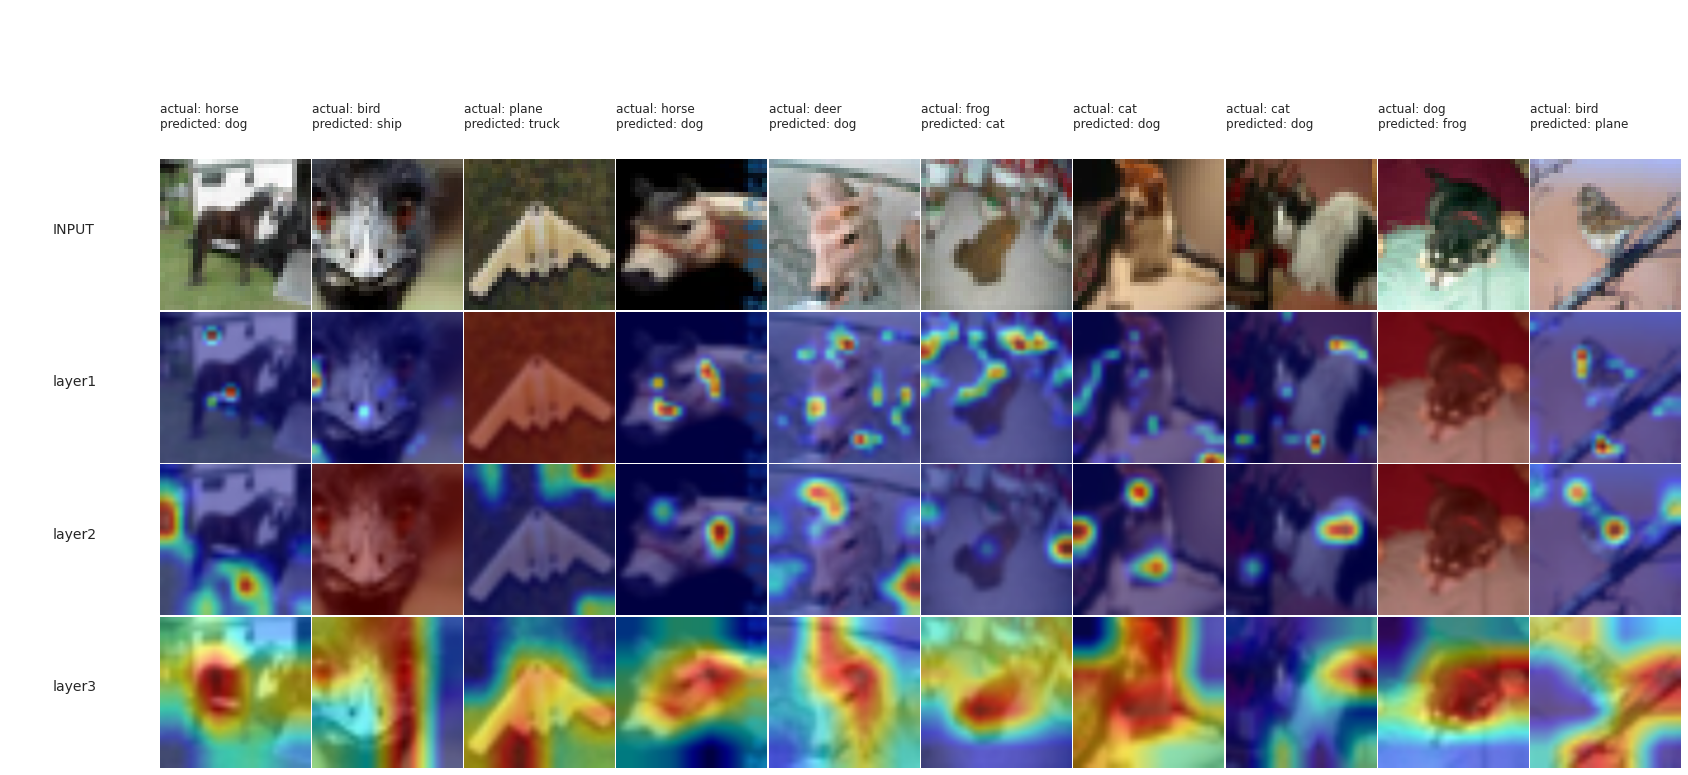

In [ ]:
target_layers = ["layer1","layer2","layer3"]
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:10], model, target_layers,device)
plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:10])

In [ ]:

# %load_ext tensorboard
# %tensorboard --logdir=runs